# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.02016531, -0.19360228, -0.02393378,  0.30643101]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.944390091331925 -3.1010570008446883


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [10]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [13]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [14]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:', np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
action size: 2


In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [35]:
state = env.reset()
#for _ in range(batch_size):
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [36]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:30.0000 R:30.0 loss:1.0921 exploreP:0.9970
Episode:1 meanR:24.5000 R:19.0 loss:1.1027 exploreP:0.9952
Episode:2 meanR:21.6667 R:16.0 loss:1.0775 exploreP:0.9936
Episode:3 meanR:21.0000 R:19.0 loss:1.1128 exploreP:0.9917
Episode:4 meanR:22.0000 R:26.0 loss:1.1094 exploreP:0.9892
Episode:5 meanR:21.3333 R:18.0 loss:1.1257 exploreP:0.9874
Episode:6 meanR:25.8571 R:53.0 loss:1.1603 exploreP:0.9822
Episode:7 meanR:24.8750 R:18.0 loss:1.1902 exploreP:0.9805
Episode:8 meanR:23.3333 R:11.0 loss:1.2484 exploreP:0.9794
Episode:9 meanR:23.0000 R:20.0 loss:1.2214 exploreP:0.9775
Episode:10 meanR:24.3636 R:38.0 loss:1.2894 exploreP:0.9738
Episode:11 meanR:24.9167 R:31.0 loss:1.3936 exploreP:0.9708
Episode:12 meanR:24.6923 R:22.0 loss:1.4386 exploreP:0.9687
Episode:13 meanR:24.4286 R:21.0 loss:1.6194 exploreP:0.9667
Episode:14 meanR:24.3333 R:23.0 loss:1.7132 exploreP:0.9645
Episode:15 meanR:23.6875 R:14.0 loss:1.8935 exploreP:0.9632
Episode:16 meanR:23.1765 R:15.0 loss:2.0230 explor

Episode:139 meanR:18.7600 R:20.0 loss:22.0969 exploreP:0.7630
Episode:140 meanR:18.6700 R:31.0 loss:23.5149 exploreP:0.7606
Episode:141 meanR:18.4200 R:12.0 loss:16.1508 exploreP:0.7597
Episode:142 meanR:18.5300 R:27.0 loss:33.5127 exploreP:0.7577
Episode:143 meanR:18.8100 R:51.0 loss:27.4942 exploreP:0.7539
Episode:144 meanR:19.3900 R:69.0 loss:19.7197 exploreP:0.7488
Episode:145 meanR:19.5400 R:42.0 loss:25.6644 exploreP:0.7457
Episode:146 meanR:19.4900 R:10.0 loss:26.0494 exploreP:0.7450
Episode:147 meanR:19.7100 R:48.0 loss:22.1746 exploreP:0.7414
Episode:148 meanR:19.9800 R:52.0 loss:18.8744 exploreP:0.7376
Episode:149 meanR:20.2600 R:45.0 loss:20.5724 exploreP:0.7344
Episode:150 meanR:20.6300 R:57.0 loss:17.0574 exploreP:0.7303
Episode:151 meanR:20.9100 R:57.0 loss:13.7116 exploreP:0.7262
Episode:152 meanR:21.5900 R:83.0 loss:21.7523 exploreP:0.7202
Episode:153 meanR:21.7700 R:30.0 loss:14.9845 exploreP:0.7181
Episode:154 meanR:21.8000 R:14.0 loss:18.2576 exploreP:0.7171
Episode:

Episode:271 meanR:69.2800 R:80.0 loss:29.3567 exploreP:0.3358
Episode:272 meanR:69.8400 R:131.0 loss:28.5670 exploreP:0.3316
Episode:273 meanR:70.6600 R:111.0 loss:23.1608 exploreP:0.3280
Episode:274 meanR:70.7300 R:62.0 loss:37.7767 exploreP:0.3261
Episode:275 meanR:71.0300 R:52.0 loss:36.4683 exploreP:0.3244
Episode:276 meanR:71.1600 R:79.0 loss:28.5593 exploreP:0.3220
Episode:277 meanR:70.8900 R:107.0 loss:26.7338 exploreP:0.3186
Episode:278 meanR:71.7100 R:108.0 loss:29.9949 exploreP:0.3153
Episode:279 meanR:71.3900 R:79.0 loss:25.8587 exploreP:0.3129
Episode:280 meanR:71.8500 R:62.0 loss:29.8670 exploreP:0.3111
Episode:281 meanR:72.4900 R:115.0 loss:28.5134 exploreP:0.3076
Episode:282 meanR:72.7000 R:59.0 loss:24.0368 exploreP:0.3059
Episode:283 meanR:71.4200 R:45.0 loss:38.6011 exploreP:0.3045
Episode:284 meanR:71.8700 R:81.0 loss:39.3006 exploreP:0.3022
Episode:285 meanR:71.4500 R:57.0 loss:31.3325 exploreP:0.3005
Episode:286 meanR:71.7600 R:44.0 loss:59.9632 exploreP:0.2992
Epi

Episode:401 meanR:281.5600 R:181.0 loss:18.9644 exploreP:0.0252
Episode:402 meanR:282.6200 R:196.0 loss:17.2327 exploreP:0.0249
Episode:403 meanR:283.8000 R:175.0 loss:7.5775 exploreP:0.0246
Episode:404 meanR:284.5500 R:147.0 loss:19.6852 exploreP:0.0244
Episode:405 meanR:285.7300 R:142.0 loss:13.7364 exploreP:0.0242
Episode:406 meanR:286.3000 R:137.0 loss:15.9595 exploreP:0.0240
Episode:407 meanR:287.1100 R:137.0 loss:32.3971 exploreP:0.0238
Episode:408 meanR:287.2900 R:104.0 loss:28.1908 exploreP:0.0237
Episode:409 meanR:286.4500 R:120.0 loss:29.8125 exploreP:0.0235
Episode:410 meanR:286.1000 R:22.0 loss:22.9387 exploreP:0.0235
Episode:411 meanR:285.3300 R:22.0 loss:0.5776 exploreP:0.0235
Episode:412 meanR:283.9200 R:103.0 loss:34.9520 exploreP:0.0233
Episode:413 meanR:283.2300 R:12.0 loss:103.9118 exploreP:0.0233
Episode:414 meanR:282.5600 R:14.0 loss:0.8546 exploreP:0.0233
Episode:415 meanR:281.2800 R:19.0 loss:43.6946 exploreP:0.0233
Episode:416 meanR:279.3200 R:17.0 loss:29.0911 

Episode:531 meanR:125.2700 R:122.0 loss:29.2009 exploreP:0.0137
Episode:532 meanR:126.0400 R:96.0 loss:29.6160 exploreP:0.0137
Episode:533 meanR:126.0600 R:100.0 loss:22.7738 exploreP:0.0136
Episode:534 meanR:126.8700 R:99.0 loss:29.4287 exploreP:0.0136
Episode:535 meanR:127.6200 R:94.0 loss:29.2530 exploreP:0.0136
Episode:536 meanR:127.4600 R:80.0 loss:21.5904 exploreP:0.0135
Episode:537 meanR:127.3500 R:85.0 loss:45.0149 exploreP:0.0135
Episode:538 meanR:125.9000 R:24.0 loss:42.3835 exploreP:0.0135
Episode:539 meanR:124.2200 R:30.0 loss:23.6099 exploreP:0.0135
Episode:540 meanR:120.8900 R:74.0 loss:22.7630 exploreP:0.0135
Episode:541 meanR:116.2300 R:20.0 loss:41.2714 exploreP:0.0135
Episode:542 meanR:113.2000 R:26.0 loss:52.2713 exploreP:0.0135
Episode:543 meanR:111.7300 R:25.0 loss:21.5555 exploreP:0.0134
Episode:544 meanR:111.2800 R:91.0 loss:47.6229 exploreP:0.0134
Episode:545 meanR:110.4900 R:69.0 loss:40.5952 exploreP:0.0134
Episode:546 meanR:109.5600 R:22.0 loss:48.0538 explor

Episode:661 meanR:93.0100 R:13.0 loss:173.4545 exploreP:0.0111
Episode:662 meanR:91.1900 R:16.0 loss:402.8449 exploreP:0.0111
Episode:663 meanR:89.5500 R:18.0 loss:437.8864 exploreP:0.0111
Episode:664 meanR:87.7700 R:16.0 loss:470.5877 exploreP:0.0111
Episode:665 meanR:85.5100 R:19.0 loss:146.0152 exploreP:0.0111
Episode:666 meanR:83.0700 R:17.0 loss:412.4325 exploreP:0.0111
Episode:667 meanR:79.9600 R:16.0 loss:145.6075 exploreP:0.0111
Episode:668 meanR:76.9400 R:15.0 loss:142.3401 exploreP:0.0111
Episode:669 meanR:73.0300 R:18.0 loss:626.4129 exploreP:0.0111
Episode:670 meanR:69.4100 R:14.0 loss:794.3378 exploreP:0.0111
Episode:671 meanR:65.7100 R:13.0 loss:58.2925 exploreP:0.0111
Episode:672 meanR:60.8500 R:14.0 loss:860.3003 exploreP:0.0111
Episode:673 meanR:59.1700 R:12.0 loss:321.8463 exploreP:0.0111
Episode:674 meanR:57.6200 R:14.0 loss:169.7905 exploreP:0.0111
Episode:675 meanR:56.0800 R:13.0 loss:942.3409 exploreP:0.0111
Episode:676 meanR:54.5500 R:15.0 loss:367.2361 exploreP:

Episode:791 meanR:411.4200 R:460.0 loss:2.9573 exploreP:0.0100
Episode:792 meanR:411.4200 R:500.0 loss:2.6087 exploreP:0.0100
Episode:793 meanR:411.4200 R:500.0 loss:2.1735 exploreP:0.0100
Episode:794 meanR:410.4700 R:405.0 loss:1.6511 exploreP:0.0100
Episode:795 meanR:408.8500 R:338.0 loss:1.1243 exploreP:0.0100
Episode:796 meanR:408.8500 R:500.0 loss:2.4483 exploreP:0.0100
Episode:797 meanR:408.8500 R:500.0 loss:3.9121 exploreP:0.0100
Episode:798 meanR:408.8500 R:500.0 loss:3.9946 exploreP:0.0100
Episode:799 meanR:408.8500 R:500.0 loss:6.0843 exploreP:0.0100
Episode:800 meanR:408.6900 R:484.0 loss:6.4312 exploreP:0.0100
Episode:801 meanR:409.1400 R:500.0 loss:3.0990 exploreP:0.0100
Episode:802 meanR:410.7600 R:500.0 loss:4.7906 exploreP:0.0100
Episode:803 meanR:410.7600 R:500.0 loss:3.1298 exploreP:0.0100
Episode:804 meanR:412.5500 R:500.0 loss:8.7183 exploreP:0.0100
Episode:805 meanR:412.5500 R:500.0 loss:9.7736 exploreP:0.0100
Episode:806 meanR:412.5500 R:500.0 loss:4.2317 exploreP

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

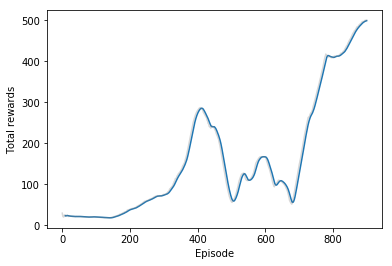

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

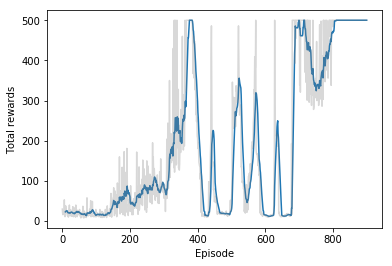

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

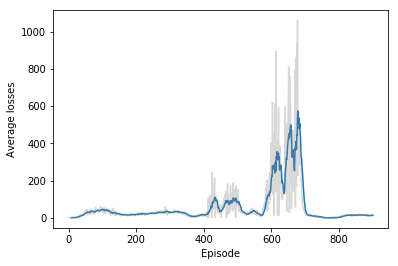

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [41]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.